In [1]:
from ext.GeoCalib.geocalib.extractor import GeoCalib
from ext.PerspectiveFields.perspective2d import PerspectiveFields
import torch
from yud import YUDVP
import numpy as np
import matplotlib.pyplot as plt

/home/tab/Desktop/EPFL/MA2/CompPhotoProject/cs413-project/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
def predict_camera_parameters(image, model):
    if type(model) == PerspectiveFields:
        prediction = model.inference(img_bgr=image)

        roll = prediction['pred_roll'].cpu().numpy()
        pitch = prediction['pred_pitch'].cpu().numpy()
        vfov = prediction['pred_general_vfov'].cpu().numpy()
        focal_length = prediction['pred_rel_focal'].cpu().numpy() * image.shape[0]

        return roll, pitch, vfov, focal_length, prediction

    elif type(model) == GeoCalib:
        # load image as tensor in range [0, 1] and in format [C, H, W]
        img_tensor = torch.tensor(image).permute(2, 0, 1) / 255.0
        image_tensor = img_tensor.to(device)
        prediction = model.calibrate(image_tensor)

        del image_tensor

        roll = prediction['camera'].roll.item()
        pitch = prediction['camera'].pitch.item()
        vfov = prediction['camera'].vfov.item()
        focal_length = prediction['camera'].f[0, 1].item()

        return roll, pitch, vfov, focal_length, prediction
    else:
        raise ValueError(f"Unknown model: {type(model)}")


def generate_camera_intrinsics(img, cx, cy, focal_length):
    # Generate camera intrinsics
    K = np.zeros((3, 3))
    K[0, 0] = focal_length
    K[1, 1] = focal_length
    K[0, 2] = cx * img.shape[1] + img.shape[1] / 2
    K[1, 2] = cy * img.shape[0] + img.shape[0] / 2
    K[2, 2] = 1.0

    return K

def extract_dataset_items(dataset, idx):
    sample = dataset[idx] # get a single sample from the dataset
    vp_gt_hom = sample['VPs'] # array Mx3 with vanishing points in homogeneous coordinates
    image = sample['image'] # RGB image
    lines = sample['line_segments'] # array Nx12 containing all extracted line segments
    p1 = lines[:, 0:3] # line segment start points in hom. coordinates
    p2 = lines[:, 3:6] # line segment end points in hom. coordinates
    hom_lines = lines[:, 6:9] # parametrised line [a,b,c] s.t. ax+by+c=0
    centroids = lines[:, 9:12] # centroid = (p1+p2)/2.

    vp0 = vp_gt_hom[0]
    vp1 = vp_gt_hom[1]
    vp2 = vp_gt_hom[2]

    vp0 = vp0 / vp0[2]
    vp1 = vp1 / vp1[2]
    vp2 = vp2 / vp2[2]

    vp0 = (int(vp0[0]), int(vp0[1]))
    vp1 = (int(vp1[0]), int(vp1[1]))
    vp2 = (int(vp2[0]), int(vp2[1]))

    vp_gt = [vp0, vp1, vp2]

    return image, sample, vp_gt

In [3]:
dataset = YUDVP("./data", split='all', normalize_coords=False, return_images=True, extract_lines=False, yudplus=False)

# This ground truth matrix K comes directly from the York Urban Dataset
K_groundtruth = np.array([
    [674.91797516, 0., 307.55130528],
    [0., 674.91797516, 251.45424496],
    [0., 0., 1.]
])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
geocalib_model = GeoCalib(weights='pinhole').to(device)

perspectivefields_uncentered_model = PerspectiveFields(version = 'Paramnet-360Cities-edina-uncentered').eval().cuda()
perspectivefields_centered_model   = PerspectiveFields(version = 'Paramnet-360Cities-edina-centered').eval().cuda()

results = []

for idx in range(len(dataset)):

    image, _, _ = extract_dataset_items(dataset, idx)

    roll, pitch, vfov, focal_length, uncentered_prediction = predict_camera_parameters(image, perspectivefields_uncentered_model)
    cx_uncentered, cy_uncentered = uncentered_prediction['pred_rel_cx'].cpu().numpy(), uncentered_prediction['pred_rel_cy'].cpu().numpy()
    K_perspective_field_uncentered = generate_camera_intrinsics(image, cx_uncentered, cy_uncentered, focal_length)
    roll, pitch, vfov, focal_length, centered_prediction = predict_camera_parameters(image, perspectivefields_centered_model)
    cx, cy = centered_prediction['pred_rel_cx'].cpu().numpy(), centered_prediction['pred_rel_cy'].cpu().numpy()
    K_perspective_field_centered = generate_camera_intrinsics(image, cx, cy, focal_length)

    # load image as tensor in range [0, 1] and in format [C, H, W]
    img_tensor = torch.tensor(image).permute(2, 0, 1) / 255.0
    image_tensor = img_tensor.to(device)
    geolib_result = geocalib_model.calibrate(image_tensor)

    focal_geolib = geolib_result['camera'].f[0, 1].item()

    K_geolib = np.zeros((3, 3))
    K_geolib[0, 0] = focal_geolib
    K_geolib[1, 1] = focal_geolib
    K_geolib[0, 2] = image.shape[1] / 2
    K_geolib[1, 2] = image.shape[0] / 2
    K_geolib[2, 2] = 1.0

    results.append((K_perspective_field_uncentered, K_perspective_field_centered, K_geolib))

results = np.array(results)

In [5]:
all_distances = [[], [], []]
count = len(results)

for tup in results:
    for i, K in enumerate(tup):
        dist = np.linalg.norm(K - K_groundtruth)
        all_distances[i].append(dist)

avg_distances = [np.mean(dists) for dists in all_distances]
std_distances = [np.std(dists) for dists in all_distances]

matrix_names = ["Perspective Fields Uncentered",
                "Perspective Fields Centered",
                "GeoCalib Pinhole"]

print("📊 Distances to Groundtruth Intrinsics Matrix K (mean ± std):")
for name, avg, std in zip(matrix_names, avg_distances, std_distances):
    print(f"{name}: {avg:.4f} ± {std:.4f}")

best_index = np.argmin(avg_distances)
print(f"\n🏆 Lowest average distance: {matrix_names[best_index]}")

📊 Distances to Groundtruth Intrinsics Matrix K (mean ± std):
Perspective Fields Uncentered: 182.8584 ± 96.9307
Perspective Fields Centered: 365.7914 ± 175.0786
GeoCalib Pinhole: 130.1741 ± 112.0270

🏆 Lowest average distance: GeoCalib Pinhole


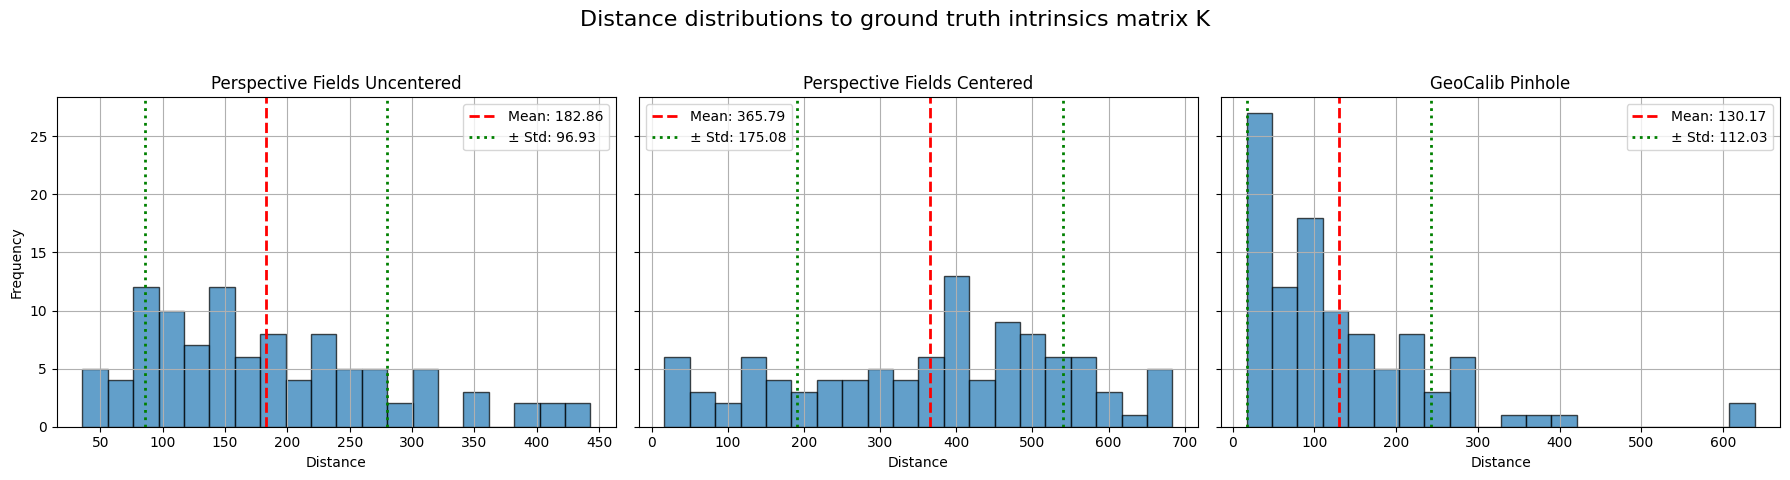

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axes):
    data = all_distances[i]
    mean = np.mean(data)
    std = np.std(data)

    ax.hist(data, bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(matrix_names[i])
    ax.set_xlabel("Distance")
    if i == 0:
        ax.set_ylabel("Frequency")
    ax.grid(True)

    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean:.2f}")
    ax.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f"± Std: {std:.2f}")
    ax.axvline(mean + std, color='green', linestyle='dotted', linewidth=2)
    ax.legend()

fig.suptitle("Distance distributions to ground truth intrinsics matrix K", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


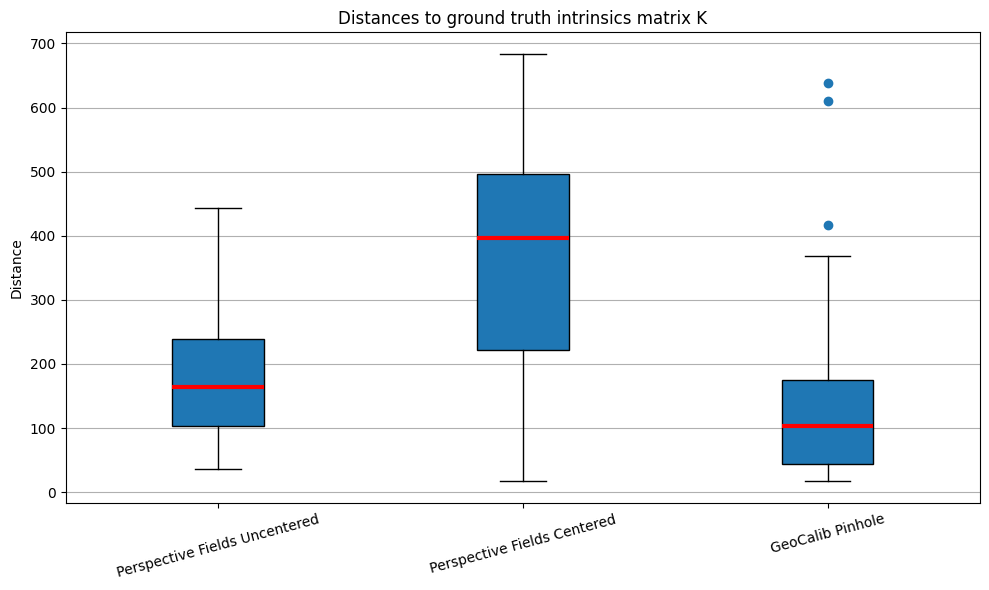

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

default_blue = '#1f77b4'

bp = ax.boxplot(
    all_distances,
    tick_labels=matrix_names,
    patch_artist=True,
    medianprops=dict(linewidth=3, color='red'),
    flierprops=dict(marker='o', markerfacecolor=default_blue, markeredgecolor=default_blue)
)

ax.set_title("Distances to ground truth intrinsics matrix K")
ax.set_ylabel("Distance")
ax.grid(True, axis='y')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

In [8]:
abs_errors = [[], [], []]
rel_errors = [[], [], []]

for tup in results:
    for i, K_est in enumerate(tup):
        fx_est, fy_est = K_est[0, 0], K_est[1, 1]
        cx_est, cy_est = K_est[0, 2], K_est[1, 2]

        fx_gt, fy_gt = K_groundtruth[0, 0], K_groundtruth[1, 1]
        cx_gt, cy_gt = K_groundtruth[0, 2], K_groundtruth[1, 2]

        abs_err = [abs(fx_est - fx_gt), abs(fy_est - fy_gt), abs(cx_est - cx_gt), abs(cy_est - cy_gt)]
        rel_err = [abs_err[0]/fx_gt, abs_err[1]/fy_gt, abs_err[2]/cx_gt, abs_err[3]/cy_gt]

        abs_errors[i].append(abs_err)
        rel_errors[i].append(rel_err)

abs_errors = [np.array(errs) for errs in abs_errors]
rel_errors = [np.array(errs) for errs in rel_errors]

abs_means = [errs.mean(axis=0) for errs in abs_errors]
rel_means = [errs.mean(axis=0) for errs in rel_errors]

parameter_names = ['fx', 'fy', 'cx', 'cy']
matrix_names = ["Perspective Fields Uncentered", "Perspective Fields Centered", "GeoCalib"]


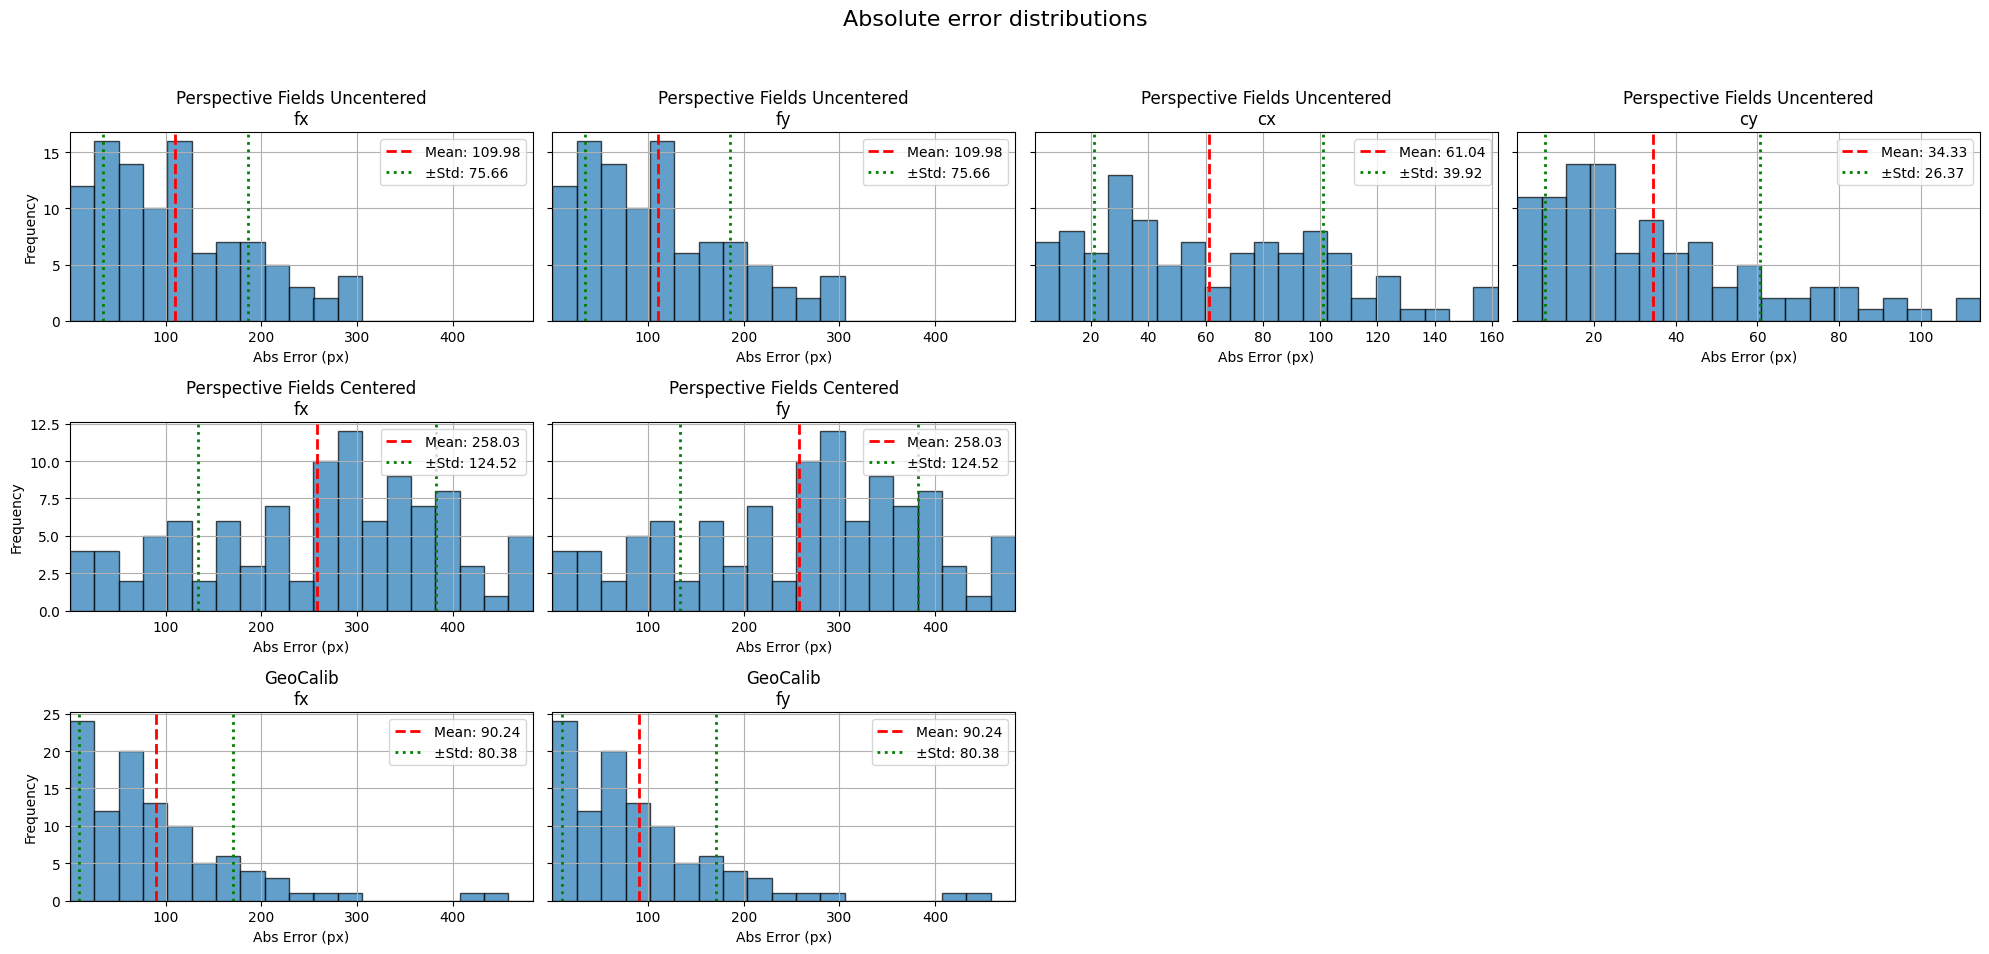

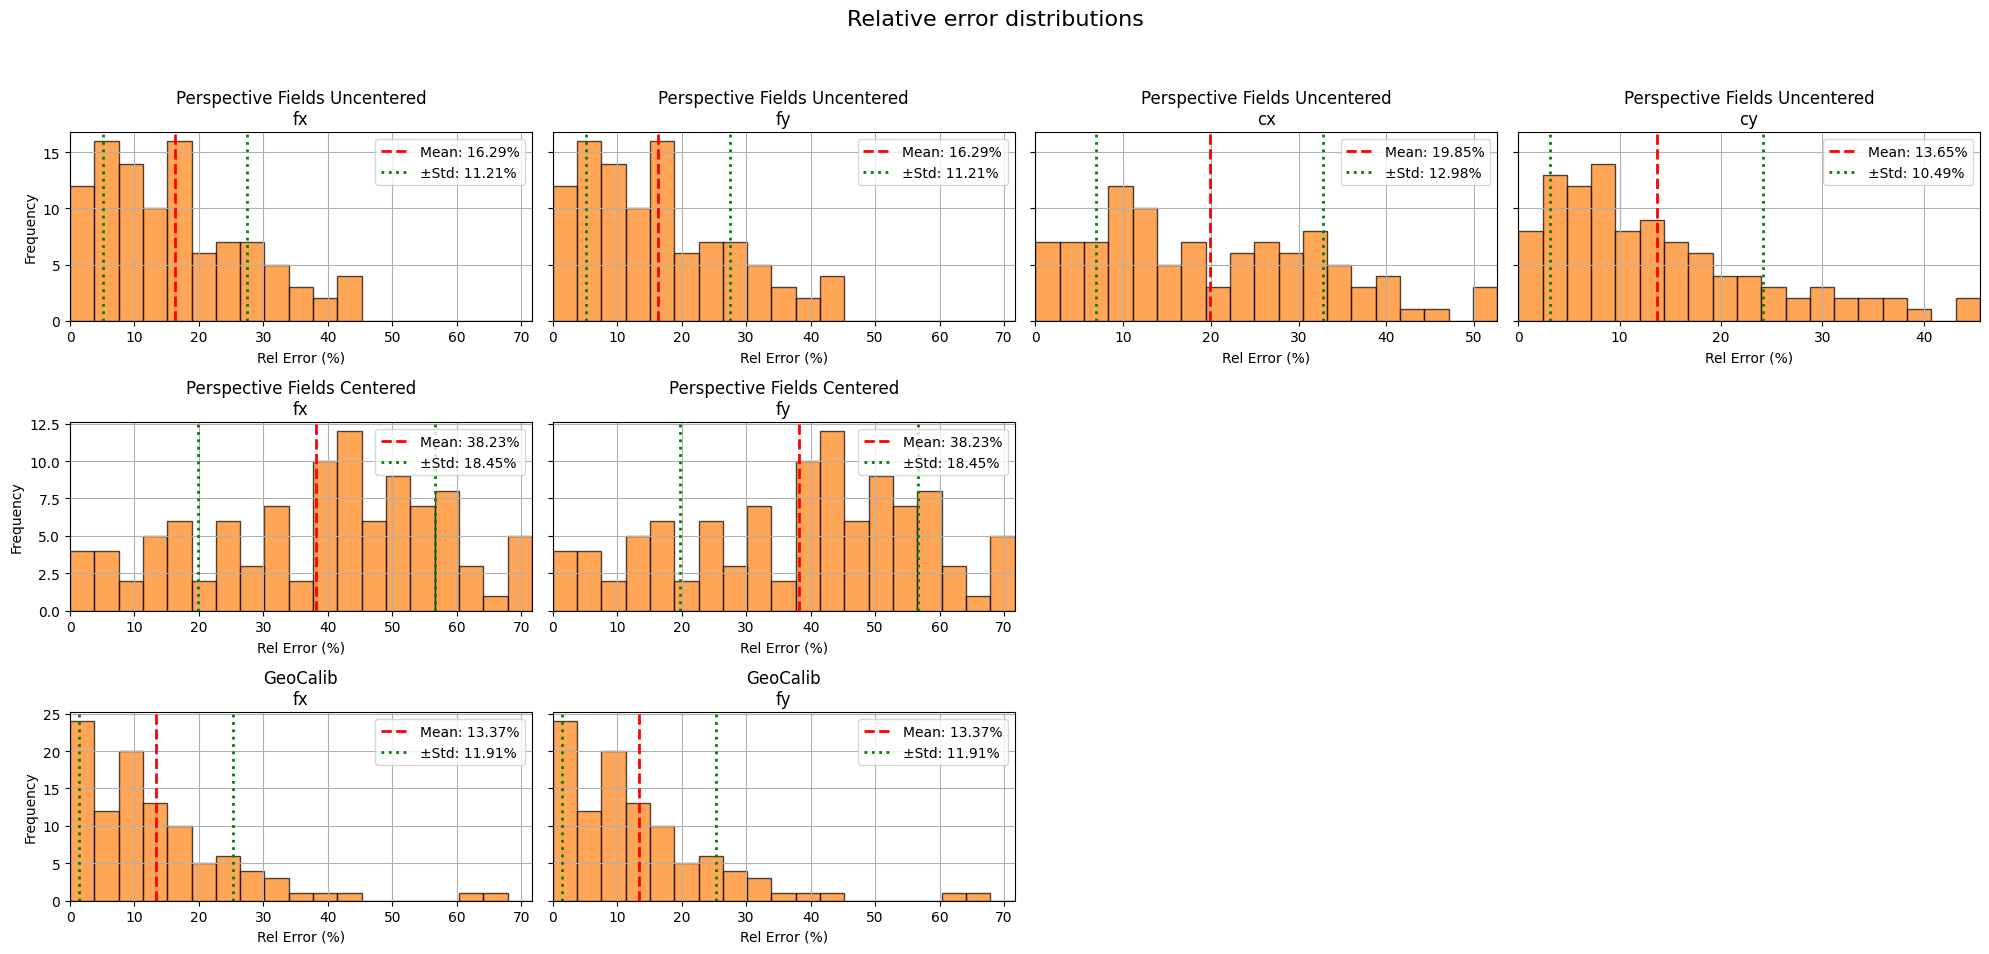

In [11]:
# --- Absolute Error Figure ---
fig_abs, axes_abs = plt.subplots(3, 4, figsize=(20, 10), sharey='row')

abs_param_ranges = [
    (min(err[:, j].min() for err in abs_errors),  # minimum across all models for param j
     max(err[:, j].max() for err in abs_errors))  # maximum across all models for param j
    for j in range(4)
]
abs_param_bins = [
    np.linspace(rng[0], rng[1], 20)
    for rng in abs_param_ranges
]

for i, name in enumerate(matrix_names):
    for j, param in enumerate(parameter_names):
        ax = axes_abs[i, j]

        # Skip cx and cy for Centered and GeoCalib models as they are always 0
        if j in [2, 3] and i in [1, 2]:
            ax.axis('off')
            continue

        data = abs_errors[i][:, j]
        mean = np.mean(data)
        std = np.std(data)

        ax.hist(data, bins=abs_param_bins[j], alpha=0.7, edgecolor='black', color='tab:blue')
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean:.2f}")
        ax.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f"±Std: {std:.2f}")
        ax.axvline(mean + std, color='green', linestyle='dotted', linewidth=2)

        ax.set_title(f"{name}\n{param}")
        ax.set_xlabel("Abs Error (px)")
        if j == 0:
            ax.set_ylabel("Frequency")
        ax.set_xlim(abs_param_ranges[j])
        ax.grid(True)
        ax.legend()

fig_abs.suptitle("Absolute error distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# --- Relative Error Figure ---
fig_rel, axes_rel = plt.subplots(3, 4, figsize=(20, 10), sharey='row')

rel_param_ranges = [
    (0, max(err[:, j].max() * 100 for err in rel_errors))  # relative errors in percent
    for j in range(4)
]
rel_param_bins = [
    np.linspace(rng[0], rng[1], 20)
    for rng in rel_param_ranges
]


for i, name in enumerate(matrix_names):
    for j, param in enumerate(parameter_names):
        ax = axes_rel[i, j]

        # Skip cx and cy for Centered and GeoCalib models as they are always 0
        if j in [2, 3] and i in [1, 2]:
            ax.axis('off')
            continue

        data = rel_errors[i][:, j] * 100
        mean = np.mean(data)
        std = np.std(data)

        ax.hist(data, bins=rel_param_bins[j], alpha=0.7, edgecolor='black', color='tab:orange')
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean:.2f}%")
        ax.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f"±Std: {std:.2f}%")
        ax.axvline(mean + std, color='green', linestyle='dotted', linewidth=2)

        ax.set_title(f"{name}\n{param}")
        ax.set_xlabel("Rel Error (%)")
        if j == 0:
            ax.set_ylabel("Frequency")
        ax.set_xlim(rel_param_ranges[j])
        ax.grid(True)
        ax.legend()

fig_rel.suptitle("Relative error distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()
